In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [3]:
#techniques.py

import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def countMultiExclamationMarks(text):
    """ Replaces repetitions of exlamation marks """
    return len(re.findall(r"(\!)\1+", text))

def countMultiQuestionMarks(text):
    """ Count repetitions of question marks """
    return len(re.findall(r"(\?)\1+", text))

def countMultiStopMarks(text):
    """ Count repetitions of stop marks """
    return len(re.findall(r"(\.)\1+", text))

def countElongated(text):
    """ Input: a text, Output: how many words are elongated """
    regex = re.compile(r"(.)\1{2}")
    return len([word for word in text.split() if regex.search(word)])

def countAllCaps(text):
    """ Input: a text, Output: how many words are all caps """
    return len(re.findall("[A-Z0-9]{3,}", text))

""" Creates a dictionary with slangs and their equivalents and replaces them """
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def countSlang(text):
    """ Input: a text, Output: how many slang words and a list of found slangs """
    slangCounter = 0
    slangsFound = []
     
    nltk.download('punkt')
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        if word in slang_words:
            slangsFound.append(word)
            slangCounter += 1
    return slangCounter, slangsFound

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


### Spell Correction begin ###
""" Spell Correction http://norvig.com/spell-correct.html """
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('corporaForSpellCorrection.txt').read()))

def P(word, N=sum(WORDS.values())): 
    """P robability of `word`. """
    return WORDS[word] / N

def spellCorrection(word): 
    """ Most probable spelling correction for word. """
    return max(candidates(word), key=P)

def candidates(word): 
    """ Generate possible spelling corrections for word. """
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    """ The subset of `words` that appear in the dictionary of WORDS. """
    return set(w for w in words if w in WORDS)

def edits1(word):
    """ All edits that are one edit away from `word`. """
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    """ All edits that are two edits away from `word`. """
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

### Spell Correction End ###

### Replace Negations Begin ###

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
      word = text[i]
      if word == 'not' and i+1 < l:
        ant = replace(text[i+1])
        if ant:
          words.append(ant)
          i += 2
          continue
      words.append(word)
      i += 1
    return words

### Replace Negations End ###

def addNotTag(text):
	""" Finds "not,never,no" and adds the tag NEG_ to all words that follow until the next punctuation """
	transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+[^\w\s]', 
       lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
       text,
       flags=re.IGNORECASE)
	return transformed

def addCapTag(word):
    """ Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_ """
    if(len(re.findall("[A-Z]{3,}", word))):
        word = word.replace('\\', '' )
        transformed = re.sub("[A-Z]{3,}", "ALL_CAPS_"+word, word)
        return transformed
    else:
        return word

# ** News headlines file**

In [4]:
import pandas as pd
from time import time
import numpy as np
import string

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:
#preprocess.py


#from techniques import *

#print("Starting preprocess..\n")

""" Tokenizes a text to its words, removes and replaces some of them """    
finalTokens = [] # all tokens

stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
allowedWordTypes = ["J","R","V","N"] #  J is Adject, R is Adverb, V is Verb, N is Noun. These are used for POS Tagging
lemmatizer = WordNetLemmatizer() # set lemmatizer
stemmer = PorterStemmer() # set stemmer

In [7]:
def tokenize(text, wordCountBefore, textID, y):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = [] # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)
    
    tokens = replaceNegations(tokens) # Technique 6: finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator) # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text) # it takes a text as an input and provides a list of every token in it
    
### NO POS TAGGING BEGIN (If you don't want to use POS Tagging keep this section uncommented) ###
    
##    for w in tokens:
##
##        if (w not in stoplist): # Technique 10: remove stopwords
##            final_word = addCapTag(w) # Technique 8: Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_
##            final_word = final_word.lower() # Technique 9: lowercases all characters
##            final_word = replaceElongated(final_word) # Technique 11: replaces an elongated word with its basic form, unless the word exists in the lexicon
##            if len(final_word)>1:
##                final_word = spellCorrection(final_word) # Technique 12: correction of spelling errors
##            final_word = lemmatizer.lemmatize(final_word) # Technique 14: lemmatizes words
##            final_word = stemmer.stem(final_word) # Technique 15: apply stemming to words

### NO POS TAGGING END ###


### POS TAGGING BEGIN (If you want to exclude words using POS Tagging, keep this section uncommented and comment the above) ###          
    
    tagged = nltk.pos_tag(tokens) # Technique 13: part of speech tagging  
    for w in tagged:

        if (w[1][0] in allowedWordTypes and w[0] not in stoplist):
            final_word = addCapTag(w[0])
            #final_word = final_word.lower()
            final_word = replaceElongated(final_word)
            if len(final_word)>1:
                final_word = spellCorrection(final_word)
            final_word = lemmatizer.lemmatize(final_word)
            final_word = stemmer.stem(final_word)

### POS TAGGING END ###
                
            onlyOneSentenceTokens.append(final_word)           
            finalTokens.append(final_word)

         
    onlyOneSentence = " ".join(onlyOneSentenceTokens) # form again the sentence from the list of tokens
    #print(onlyOneSentence) # print final sentence

    
    """ Write the preprocessed text to file """
    with open("result_toi_3.txt", "a") as result:
        result.write(textID+"\t"+y+"\t"+onlyOneSentence+"\n")
        
    return finalTokens

In [8]:

print("Starting preprocess..\n")

f = open("timesofindia_csv/toi3.txt","r", encoding="utf8", errors='replace').read()

t0 = time()
totalSentences = 0
totalEmoticons = 0
totalSlangs = 0
totalSlangsFound = []
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

for line in f.split('\n'):
    totalSentences += 1
    feat = []
    columns = line.split('\t')
    columns = [col.strip() for col in columns]

    print("line" + line)

    textID = (columns[0])
    y = (columns[2])

    text = removeUnicode(columns[1]) # Technique 0
    #print(text) # print initial text
    wordCountBefore = len(re.findall(r'\w+', text)) # word count of one sentence before preprocess    
    #print("Words before preprocess: ",wordCountBefore,"\n")
    
    text = replaceURL(text) # Technique 1
    text = replaceAtUser(text) # Technique 1
    text = removeHashtagInFrontOfWord(text) # Technique 1

    temp_slangs, temp_slangsFound = countSlang(text)
    totalSlangs += temp_slangs # total slangs for all sentences
    for word in temp_slangsFound:
        totalSlangsFound.append(word) # all the slangs found in all sentences
    
    text = replaceSlang(text) # Technique 2: replaces slang words and abbreviations with their equivalents
    text = replaceContraction(text) # Technique 3: replaces contractions to their equivalents
    text = removeNumbers(text) # Technique 4: remove integers from text

    emoticons = countEmoticons(text) # how many emoticons in this sentence
    totalEmoticons += emoticons
    
    text = removeEmoticons(text) # removes emoticons from text

    
    totalAllCaps += countAllCaps(text)

    totalMultiExclamationMarks += countMultiExclamationMarks(text) # how many repetitions of exlamation marks in this sentence
    totalMultiQuestionMarks += countMultiQuestionMarks(text) # how many repetitions of question marks in this sentence
    totalMultiStopMarks += countMultiStopMarks(text) # how many repetitions of stop marks in this sentence
    
    text = replaceMultiExclamationMark(text) # Technique 5: replaces repetitions of exlamation marks with the tag "multiExclamation"
    text = replaceMultiQuestionMark(text) # Technique 5: replaces repetitions of question marks with the tag "multiQuestion"
    text = replaceMultiStopMark(text) # Technique 5: replaces repetitions of stop marks with the tag "multiStop"

    totalElongated += countElongated(text) # how many elongated words emoticons in this sentence
    
    tokens = tokenize(text, wordCountBefore, textID, y)  

    #print("end")
    


Output hidden; open in https://colab.research.google.com to view.

Total sentences:  10000 

Total Words before preprocess:  122273
Total Distinct Tokens before preprocess:  28219
Average word/sentence before preprocess:  12.2273 

Total Words after preprocess:  71825
Total Distinct Tokens after preprocess:  9805
Average word/sentence after preprocess:  7.1825 

Total run time:  2614.366790294647  seconds

Total emoticons:  3056 

Total slangs:  118 

vs 	 69
app 	 23
pro 	 5
aka 	 4
flick 	 3
bestie 	 3
deets 	 3
ga 	 2
rly 	 1
u 	 1
r 	 1
pls 	 1
x 	 1
uber 	 1


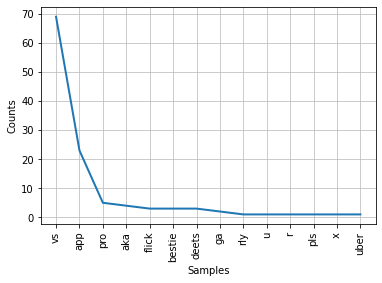

Total elongated words:  19 

Total multi exclamation marks:  3
Total multi question marks:  0
Total multi stop marks:  10 

Total all capitalized words:  1589 

Most common words 
Word	Count
of 	 1082
india 	 421
get 	 397
delhi 	 349
new 	 344
say 	 309
year 	 272
high 	 258
first 	 257
than 	 242
take 	 223
make 	 207
lumbar 	 207
lodi 	 204
vapor 	 202
student 	 193
meet 	 190
set 	 189
famili 	 187
may 	 183
woman 	 182
celebr 	 177
day 	 174
open 	 172
is 	 169
win 	 167
today 	 166
june 	 159
give 	 159
help 	 158
maharashtra 	 158
film 	 155
west 	 153
look 	 153
work 	 151
world 	 147
time 	 146
run 	 143
citi 	 141
bengaluru 	 141
govern 	 140
court 	 138
chennai 	 137
life 	 135
pictur 	 133
elect 	 132
gandhi 	 131
kolkata 	 131
road 	 130
top 	 129
univers 	 129
launch 	 127
human 	 126
minist 	 125
next 	 122
and 	 121
case 	 119
trade 	 117
share 	 117
show 	 116
chief 	 116
to 	 116
indian 	 116
birthday 	 114
core 	 114
girl 	 113
al_caps_bjp 	 113
congress 	 113
love 	

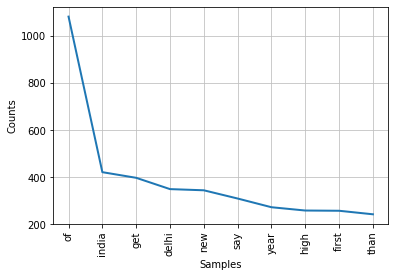

Most common collocations (bigrams)
[('kasauti', 'zindagi'), ('ooltah', 'chashmah'), ('tamilisai', 'soundararajan'), ('joaquin', 'phoenix'), ('nushrat', 'bharucha'), ('riteish', 'deshmukh'), ('kundali', 'bhagya'), ('angina', 'ranaut'), ('gautam', 'gambhir'), ('mayank', 'agarw'), ('lesser', 'known'), ('al_caps_gif', 'wallpap'), ('ghatasthapana', 'signific'), ('roger', 'sever'), ('austin', 'timber'), ('panama', 'vihari'), ('robert', 'atkinson'), ('mile', 'cyru'), ('sourav', 'ganguli'), ('harder', 'samovar'), ('given', 'rijiju'), ('sidharth', 'shukla'), ('viva', 'jyothi'), ('samsung', 'galaxi'), ('rape', 'survivor'), ('thumb', 'pednekar'), ('nobl', 'laureat'), ('mari', 'com'), ('manor', 'tiwari'), ('machin', 'tendulkar'), ('jasprit', 'hurrah'), ('ok', 'masha'), ('nirmala', 'sitharaman'), ('cool', 'casual'), ('dipika', 'makar'), ('pua', 'ghatasthapana'), ('udhav', 'thackeray'), ('ajinkya', 'latan'), ('aaditya', 'thackeray'), ('fro', 'kabadi'), ('marian', 'akhtar'), ('known', 'fact'), ('salm

In [9]:
print("Total sentences: ",totalSentences,"\n")
print("Total Words before preprocess: ",len(re.findall(r'\w+', f)))
print("Total Distinct Tokens before preprocess: ",len(set(re.findall(r'\w+', f))))
print("Average word/sentence before preprocess: ",len(re.findall(r'\w+', f))/totalSentences,"\n")
print("Total Words after preprocess: ",len(tokens))
print("Total Distinct Tokens after preprocess: ",len(set(tokens)))
print("Average word/sentence after preprocess: ",len(tokens)/totalSentences,"\n")


print("Total run time: ",time() - t0," seconds\n")

print("Total emoticons: ",totalEmoticons,"\n")
print("Total slangs: ",totalSlangs,"\n")
commonSlangs = nltk.FreqDist(totalSlangsFound)
for (word, count) in commonSlangs.most_common(20): # most common slangs across all texts
    print(word,"\t",count)

commonSlangs.plot(20, cumulative=False) # plot most common slangs

print("Total elongated words: ",totalElongated,"\n")
print("Total multi exclamation marks: ",totalMultiExclamationMarks)
print("Total multi question marks: ",totalMultiQuestionMarks)
print("Total multi stop marks: ",totalMultiStopMarks,"\n")
print("Total all capitalized words: ",totalAllCaps,"\n")

#print(tokens)
commonWords = nltk.FreqDist(tokens)
print("Most common words ")
print("Word\tCount")
for (word, count) in commonWords.most_common(100): # most common words across all texts
    print(word,"\t",count)

commonWords.plot(10, cumulative=False) # plot most common words

bgm = nltk.collocations.BigramAssocMeasures()
tgm = nltk.collocations.TrigramAssocMeasures()
bgm_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
tgm_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bgm_finder.apply_freq_filter(5) # bigrams that occur at least 5 times
print("Most common collocations (bigrams)")
print(bgm_finder.nbest(bgm.pmi, 50)) # top 50 bigram collocations
tgm_finder.apply_freq_filter(5) # trigrams that occur at least 5 times
print("Most common collocations (trigrams)")
print(tgm_finder.nbest(tgm.pmi, 20)) # top 20 trigrams collocations